# Ejercicio 

El objetivo de este trabajo es comprobar si las restricciones de tráfico establecidas en Madrid Central han servido para reducir significativamente las emisiones de gases contaminantes.

### Conjunto de datos

Datos abiertos del Ayuntamiento de Madrid: [Calidad del aire. Datos diarios años 2001 a 2019](http://aprendeconalf.es/python/trabajos/datos/emisiones-madrid.csv).

# Solución

## Preprocesamiento de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

# Códigos de las magnitudes contaminantes medidas
magnitudes = {
    '01':'Dióxido de Azufre',
    '06':'Monóxido de Carbono',
    '07':'Monóxido de Nitrógeno',
    '08':'Dióxido de Nitrógeno',
    '09':'Partículas < 2.5 μm',
    '10':'Partículas < 10 μm',
    '12':'Óxidos de Nitrógeno',
    '14':'Ozono',
    '20':'Tolueno',
    '30':'Benceno',
    '35':'Etilbenceno',
    '37':'Metaxileno',
    '38':'Paraxileno',
    '39':'Ortoxileno',
    '42':'Hidrocarburos totales(hexano)',
    '43':'Metano',
    '44':'Hidrocarburosno metánicos (hexano)'
}

# Códigos de las estaciones de medición.
estaciones = {
    '001':'Pº. Recoletos',
    '002':'Glta. de Carlos V',
    '035':'Pza. del Carmen',
    '004':'Pza. de España',
    '039':'Barrio del Pilar',
    '006':'Pza. Dr. Marañón',
    '007':'Pza. M. de Salamanca',
    '008':'Escuelas Aguirre',
    '009':'Pza. Luca de Tena',
    '038':'Cuatro Caminos',
    '011':'Av. Ramón y Cajal',
    '012':'Pza. Manuel Becerra',
    '040':'Vallecas',
    '014':'Pza. Fdez. Ladreda',
    '015':'Pza. Castilla',
    '016':'Arturo Soria', 
    '017':'Villaverde Alto',
    '018':'Calle Farolillo',
    '019':'Huerta Castañeda',
    '036':'Moratalaz',
    '021':'Pza. Cristo Rey',
    '022':'Pº. Pontones',
    '023':'Final C/ Alcalá',
    '024':'Casa de Campo',
    '025':'Santa Eugenia',
    '026':'Urb. Embajada (Barajas)',
    '027':'Barajas',
    '047':'Méndez Álvaro',
    '048':'Pº. Castellana',
    '049':'Retiro',
    '050':'Pza. Castilla',
    '054':'Ensanche Vallecas',
    '055':'Urb. Embajada (Barajas)',
    '056':'Plaza Elíptica',
    '057':'Sanchinarro',
    '058':'El Pardo',
    '059':'Parque Juan Carlos I',
    '060':'Tres Olivos'
}

# Carga de datos
from urllib.error import HTTPError

try:
    df = pd.read_csv('http://aprendeconalf.es/python/trabajos/datos/emisiones-madrid.csv')
except HTTPError:
    print('La url no existe')
else:
    # Preprocesamiento de datos
    # Pasar los días de columnas a una nueva variable DIA
    df = df.melt(id_vars=['ESTACION', 'MAGNITUD', 'ANO', 'MES'], var_name='DIA', value_name='VALOR')
    # Eliminar la D del valor de los días
    df['DIA'] = df['DIA'].apply(lambda x: x[1:])
    # Convertir las columnas DIA, MES, ANO, ESTACION y MAGNITUD en cadenas
    df['ESTACION'] = df['ESTACION'].astype(str)
    df['MAGNITUD'] = df['MAGNITUD'].astype(str)
    df['MES'] = df['MES'].astype(str)
    df['ANO'] = df['ANO'].astype(str)
    # Añadir 00 a la estación cuando la estación solo tiene un dígito y 0 cuando tiene dos
    df['ESTACION'] = df['ESTACION'].apply(
        lambda x: '00' + x if len(x) < 2 else '0' + x)
    # Añadir 0 a la magnitud cuando solo tiene un dígito
    df['MAGNITUD'] = df['MAGNITUD'].apply(lambda x: '0' + x if len(x) < 2 else x)
    # Añadir 0 al mes cuando el mes solo tiene un dígito
    df['MES'] = df['MES'].apply(lambda x: '0' + x if len(x) < 2 else x)
    # Crear una nueva columna concatenando las columnas DIA, MES y AÑO en formato dd/mm/aaaa
    df['FECHA'] = df['DIA'] + '/' + df['MES'] + '/' + df['ANO']
    # Convertir la columna fecha al tipo datetime
    df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d/%m/%Y', errors='coerce')
    # Eliminar las filas con fechas no válidas
    df = df.drop(df[np.isnat(df['FECHA'])].index)
    # Ordenar el dataframe por fechas, magnitudes y estaciones
    df = df.sort_values(['FECHA', 'MAGNITUD', 'ESTACION'])

    print(df)

ESTACION MAGNITUD   ANO MES DIA  VALOR      FECHA
0          004       01  2018  01  01   1.00 2018-01-01
60         008       01  2018  01  01   3.00 2018-01-01
360        017       01  2018  01  01   3.00 2018-01-01
420        018       01  2018  01  01   6.00 2018-01-01
540        024       01  2018  01  01   3.00 2018-01-01
...        ...      ...   ...  ..  ..    ...        ...
71927      024       43  2019  04  30   1.21 2019-04-30
72199      055       43  2019  04  30   1.36 2019-04-30
71771      008       44  2019  04  30   0.07 2019-04-30
71931      024       44  2019  04  30   0.06 2019-04-30
72203      055       44  2019  04  30   0.12 2019-04-30

[73052 rows x 7 columns]


1. Crear una función que reciba una estación de medición y una magnitud y devuelva una lista con todas las mediciones de la magnitud en la estación.

In [2]:
def estacion_magnitud(df, estacion, magnitud):
    """
    Función que devuelve la lista de valores de una estación y magnitud.
    Parámetros: 
        - df: Es un DataFrame con la información de la base de datos de emisiones.
        - estacion: Es una cadena con el código de la estación de medición.
        - magnitud: Es una cadena el código de la magnitud medida.
    Devuelve:
        Una lista con los valores de la magnitud medidos en la estación indicada.
    """
    # Filtro de la estación y la magnitud
    df1 = df[(df['ESTACION'] == estacion) & (df['MAGNITUD'] == magnitud)]
    return list(df1['VALOR'])

# Ejemplo
print(estacion_magnitud(df, '050', '12'))


[39.0, 80.0, 94.0, 89.0, 70.0, 54.0, 38.0, 104.0, 195.0, 121.0, 101.0, 196.0, 158.0, 51.0, 135.0, 150.0, 138.0, 191.0, 152.0, 111.0, 92.0, 148.0, 177.0, 163.0, 179.0, 99.0, 37.0, 22.0, 87.0, 121.0, 174.0, 193.0, 77.0, 71.0, 47.0, 79.0, 67.0, 107.0, 94.0, 202.0, 68.0, 95.0, 89.0, 120.0, 89.0, 135.0, 122.0, 60.0, 30.0, 60.0, 75.0, 58.0, 107.0, 107.0, 113.0, 93.0, 160.0, 149.0, 140.0, 78.0, 113.0, 71.0, 73.0, 110.0, 120.0, 97.0, 127.0, 92.0, 85.0, 57.0, 83.0, 122.0, 94.0, 90.0, 109.0, 87.0, 68.0, 98.0, 80.0, 70.0, 134.0, 128.0, 39.0, 47.0, 86.0, 86.0, 105.0, 36.0, 31.0, 41.0, 46.0, 68.0, 73.0, 69.0, 84.0, 87.0, 70.0, 58.0, 79.0, 92.0, 100.0, 87.0, 96.0, 67.0, 55.0, 76.0, 102.0, 78.0, 50.0, 32.0, 35.0, 47.0, 60.0, 59.0, 99.0, 83.0, 85.0, 41.0, 36.0, 71.0, 46.0, 52.0, 70.0, 34.0, 36.0, 28.0, 71.0, 109.0, 73.0, 43.0, 73.0, 51.0, 39.0, 60.0, 26.0, 35.0, 47.0, 46.0, 30.0, 17.0, 52.0, 77.0, 65.0, 34.0, 97.0, 66.0, 47.0, 73.0, 72.0, 86.0, 88.0, 86.0, 27.0, 40.0, 55.0, 76.0, 59.0, 78.0, 61.0, 55.

2. Crear una función que reciba un mes y una estación de medición y devuelva un diccionario con las medias de las magnitudes medidas por la estación durante ese mes.

In [3]:
def medias_mes_estacion(df, mes, estacion):
    """
    Función que devuelve la media de las magnitudes medidas en una estación en un mes concreto.
    Parámetros:
        - df: Es un DataFrame con la información de la base de datos de emisiones.
        - mes: Es una cadena de dos caractares con el número de mes en formato mm.
        - estacion: Es una cadena con el código de la estación de medición.
    Devuelve:
        Un diccionario cuyos pares tienen como clave las magnitudes y como valores las medias del mes en la estación indicada.
    """ 
    # Filtro de la estación y el mes
    df1 = df[(df['ESTACION'] == estacion) & (df['MES'] == mes)]
    # Agrupación por magnitud y cálculo de la media
    return {magnitudes[k]:np.mean(v) for k, v in df1.groupby('MAGNITUD')['VALOR']}

# Ejemplo
print(medias_mes_estacion(df, '03', '050'))

{'Monóxido de Nitrógeno': 21.161290322580644, 'Dióxido de Nitrógeno': 38.04838709677419, 'Partículas < 2.5 μm': 6.435483870967742, 'Partículas < 10 μm': 11.564516129032258, 'Óxidos de Nitrógeno': 70.40322580645162}


3. Crear una función que reciba un mes y una magnitud y devuelva un diccionario con las medias de las estaciones de medición de la magnitud durante ese mes.

In [4]:
def medias_mes_magnitud(df, mes, magnitud):
    """
    Función que devuelve la media de una magnitud en mes concreto en cada estación de medición.
    Parámetros:
        - df: Es un DataFrame con la información de la base de datos de emisiones.
        - mes: Es una cadena de dos caractares con el número de mes en formato mm.
        - magnitud: Es una cadena con el código de la magnitud medida.
    Devuelve:
        Un diccionario cuyos pares tienen como clave las estaciones y como valores las medias del mes de la magnitud indicada.
    """ 
    # Filtro de la magnitud y el mes
    df1 = df[(df['MAGNITUD'] == magnitud) & (df['MES'] == mes)]
    # Agrupación por estación y cálculo de la media
    return {estaciones[k]:np.mean(v) for k, v in df1.groupby('ESTACION')['VALOR']}

# Ejemplo
print(medias_mes_magnitud(df, '12', '12'))


{'Pza. de España': 183.1290322580645, 'Escuelas Aguirre': 176.96774193548387, 'Av. Ramón y Cajal': 144.3548387096774, 'Arturo Soria': 129.4516129032258, 'Villaverde Alto': 203.70967741935485, 'Calle Farolillo': 143.83870967741936, 'Casa de Campo': 79.29032258064517, 'Barajas': 135.80645161290323, 'Pza. del Carmen': 151.70967741935485, 'Moratalaz': 146.38709677419354, 'Cuatro Caminos': 183.80645161290323, 'Barrio del Pilar': 183.83870967741936, 'Vallecas': 130.25806451612902, 'Méndez Álvaro': 142.51612903225808, 'Pº. Castellana': 124.80645161290323, 'Retiro': 103.35483870967742, 'Pza. Castilla': 140.90322580645162, 'Ensanche Vallecas': 148.70967741935485, 'Urb. Embajada (Barajas)': 168.38709677419354, 'Plaza Elíptica': 203.58064516129033, 'Sanchinarro': 128.51612903225808, 'El Pardo': 50.96774193548387, 'Parque Juan Carlos I': 93.3225806451613, 'Tres Olivos': 105.06451612903226}


4. Crear una función que reciba un rango de fechas y una estación de medición y genere un gráfico con la evolución diaria de las magnitudes de esa estación en las fechas indicadas.

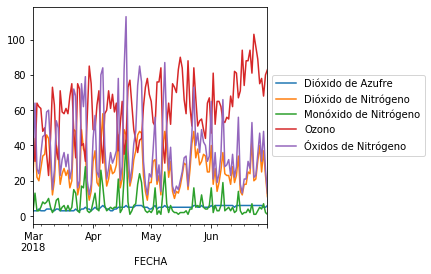

In [5]:
def evolucion_estacion(df, estacion, inicio, fin):
    """
    Función que crea un gráfico con la evolución de las magnitudes de una estación de medición en un rango de fechas.
    Parámetros:
        - df: Es un DataFrame con la información de la base de datos de emisiones.
        - estacion: Es una cadena con el código de la estacion de medición.
        - inicio: Es una cadena con la fecha inicial en formato dd-mm-aaaa.
        - fin: Es una cadena con la fecha final en formato dd-mm-aaaa.
    """
    # Añadir columna con el nombre de las magnitudes
    df['NOMBRE MAGNITUD'] = df['MAGNITUD'].apply(lambda x: magnitudes[x])
    # Filtro de la estación y rango de fechas
    df1 = df[(df['ESTACION'] == estacion) & (df['FECHA'] >= inicio) & (df['FECHA'] <= fin)]
    # Establecemos la columna fecha como índice del DataFrame
    df1.set_index('FECHA', inplace = True)
    # Inicializamos el gráfico
    fig, ax = plt.subplots()
    # Agrupamos los datos por magnitud y generamos el gráfico de líneas
    df1.groupby('NOMBRE MAGNITUD')['VALOR'].plot(legend = True)
    # Reducimos el eje x un 30% para que quepa la leyenda
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # Dibujar la leyenda fuera del área del gráfico
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # Guardamos el gráfico.
    plt.show()
    return

# Ejemplo
evolucion_estacion(df, '017', '2018-03-01', '2018-06-30')


5. Crear una función que reciba un rango de fechas y una magnitud y genere un gráfico con la evolución diaria de la magnitud para cada estación de medición en las fechas indicadas.

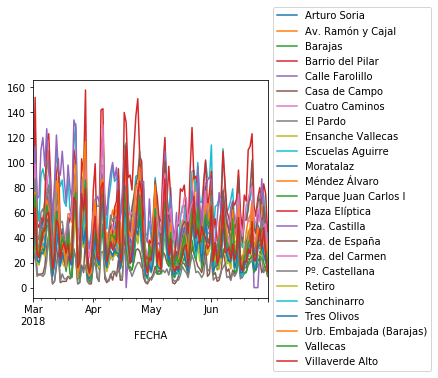

In [6]:
def evolucion_magnitud(df, magnitud, inicio, fin):
    """
    Función que crea un gráfico con la evolución de las mediciones de una magnitud en cada estación en un rango de fechas.
    Parámetros:
        - df: Es un DataFrame con la información de la base de datos de emisiones.
        - magnitud: Es una cadena con el código de la magnitud medida.
        - inicio: Es una cadena con la fecha inicial en formato dd-mm-aaaa.
        - fin: Es una cadena con la fecha final en formato dd-mm-aaaa.
    """
    # Añadir columna con el nombre de las estaciones
    df['NOMBRE ESTACION'] = df['ESTACION'].apply(lambda x: estaciones[x])
    # Filtro de la magnitud y el rango de fechas
    df1 = df[(df['MAGNITUD'] == magnitud) & (df['FECHA'] >= inicio) & (df['FECHA'] <= fin)]
    # Establecemos la columna fecha como índice del DataFrame
    df1.set_index('FECHA', inplace = True)
    # Inicializamos el gráfico
    fig, ax = plt.subplots()
    # Agrupamos los datos por estación y generamos el gráfico de líneas.
    df1.groupby('NOMBRE ESTACION')['VALOR'].plot(legend = True)
    # Reducimos el eje x un 30% para que quepa la leyenda
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # Dibujar la leyenda fuera del área del gráfico
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # Guardamos el gráfico
    plt.show()
    return

# Ejemplo
evolucion_magnitud(df, '12', '2018-03-01', '2018-06-30')


6. Crear una función que reciba una magnitud y genere un gráfico con las medias mensuales para cada estación de medición.

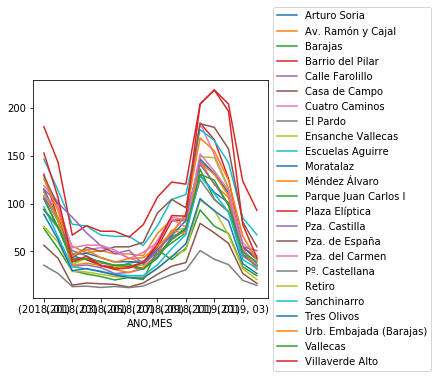

In [7]:
def evolucion_medias_magnitud(df, magnitud):
    """
    Función que crea un gráfico con la evolución de las medias de una magnitud en cada estación.
    Parámetros:
        - df: Es un DataFrame con la información de la base de datos de emisiones.
        - magnitud: Es una cadena con el código de la magnitud medida.
    """
    # Añadir columna con el nombre de las estaciones
    df['NOMBRE ESTACION'] = df['ESTACION'].apply(lambda x: estaciones[x])
    # Filtro de la magnitud
    df1 = df[df['MAGNITUD'] == magnitud]
    # Establecemos la columna fecha como índice del DataFrame
    df1.set_index('FECHA', inplace = True)
    # Inicializamos el gráfico
    fig, ax = plt.subplots()
    # Agrupamos los datos por estación y generamos el gráfico de líneas.
    df1.groupby(['ANO','MES','NOMBRE ESTACION']).mean().unstack()['VALOR'].plot(ax = ax, legend = True)
    # Reducimos el eje x un 30% para que quepa la leyenda
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # Dibujar la leyenda fuera del área del gráfico
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # Guardamos el gráfico
    plt.show()
    return

# Ejemplo
evolucion_medias_magnitud(df, '12')
